# **U-Net 모델 구현**

✅ 아래 코드는 PyTorch로 작성한 간단한 U-Net 모델입니다.

✅ 주요 목표: 작은 이미지 세트로 segmentation 학습을 테스트하기!

✅ 특징: 업샘플링(deconv/upsample 선택 가능), 입력 스케일링, Gaussian noise 추가, 배치 정규화 적용

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# --- 작은 U-Net 정의 ---
class UNetSmall(nn.Module):
    def __init__(self, upsample_mode='deconv', net_scaling=None, edge_crop=0, gaussian_noise_std=0.1):
        super().__init__()
        self.net_scaling = net_scaling
        self.edge_crop = edge_crop
        self.gaussian_noise_std = gaussian_noise_std
        self.upsample_mode = upsample_mode

        # Convolution Block: Conv -> ReLU -> Conv -> ReLU
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        # 인코더 부분 목표 -> 128 까지!
        self.enc1 = conv_block(3, 16)
        self.enc2 = conv_block(16, 32)
        self.enc3 = conv_block(32, 64)
        self.enc4 = conv_block(64, 128)
        # Bottleneck
        self.center = conv_block(128, 128)
        self.pool = nn.MaxPool2d(2)

        # 업샘플링 부분 정의 (deconv 또는 upsample+conv)
        if upsample_mode == 'deconv':
            def upsample_layer(in_c, out_c):
                return nn.ConvTranspose2d(in_c, out_c, 2, stride=2)
        else:
            def upsample_layer(in_c, out_c):
                return nn.Sequential(
                    nn.Upsample(scale_factor=2, mode='nearest'),
                    nn.Conv2d(in_c, out_c, 1)
                )

        # 디코더 부분
        self.up4 = upsample_layer(128, 128)
        self.dec4 = conv_block(256, 64)
        self.up3 = upsample_layer(64, 64)
        self.dec3 = conv_block(128, 32)
        self.up2 = upsample_layer(32, 32)
        self.dec2 = conv_block(64, 16)
        self.up1 = upsample_layer(16, 16)
        self.dec1 = conv_block(32, 16)

        # 최종 출력: 1채널(segmentation mask)
        self.final = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        if self.net_scaling:
            # 입력 스케일링
            x = F.avg_pool2d(x, self.net_scaling)
        # Gaussian noise 추가
        if self.gaussian_noise_std:
            noise = torch.randn_like(x) * self.gaussian_noise_std
            x = x + noise

        # 배치 정규화 적용
        x = F.batch_norm(x, running_mean=None, running_var=None, training=True)

        # 인코더
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        # Bottleneck
        center = self.center(self.pool(e4))

        # 디코더 + Skip Connection
        d4 = self.up4(center)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.final(d1)
        out = torch.sigmoid(out)
        # Crop + Pad
        if self.edge_crop > 0:
            out = out[:, :, self.edge_crop:-self.edge_crop, self.edge_crop:-self.edge_crop]
            out = F.pad(out, (self.edge_crop, self.edge_crop, self.edge_crop, self.edge_crop))
        # Upsample 다시 확대
        if self.net_scaling:
            out = F.interpolate(out, scale_factor=self.net_scaling, mode='nearest')

        return out


## **학습용 데이터 생성하기**

In [2]:
batch_size = 32
x = torch.randn(batch_size, 3, 128, 128)  # RGB 이미지
y = (torch.rand(batch_size, 1, 128, 128) > 0.5).float()  # 랜덤 이진 마스크

dataset = TensorDataset(x, y)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

## **데이터 시각화**

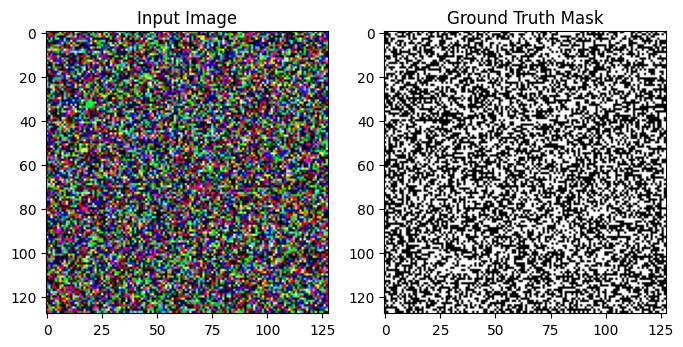

In [3]:
import matplotlib.pyplot as plt
# 첫 번째 이미지를 시각화
sample_x = x[0]
sample_y = y[0]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_x.permute(1, 2, 0).numpy())
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(sample_y.squeeze().numpy(), cmap='gray')
plt.title('Ground Truth Mask')
plt.show()

## **모델 선언 및 학습**

In [4]:
# --- 모델 선언 및 학습 ---
model = UNetSmall(upsample_mode='deconv', net_scaling=None, edge_crop=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

# 간단히 30 epoch만
for epoch in range(10):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")

Epoch 1, Loss: 0.6943
Epoch 2, Loss: 0.6932
Epoch 3, Loss: 0.6932
Epoch 4, Loss: 0.6931
Epoch 5, Loss: 0.6931
Epoch 6, Loss: 0.6931
Epoch 7, Loss: 0.6931
Epoch 8, Loss: 0.6931
Epoch 9, Loss: 0.6931
Epoch 10, Loss: 0.6930


## **아래 주석을 풀고 U-Net 모델에 대해 간단히 설명해주세요 😀**

[답변]


---

U-Net은 의료 영상 등에서 픽셀 단위로 구분(segmentation) 하기 위해 설계된 합성곱 신경망 구조로, 입력 이미지의 공간 정보를 잃지 않으면서도 전역적인 맥락(context)을 학습할 수 있다는 특징을 가진다. 구조는 크게 인코더(Contracting path) 와 디코더(Expanding path) 두 부분으로 나뉘며, 인코더는 여러 층의 합성곱(conv)과 풀링(pooling)을 통해 이미지의 특징을 추출하고 점차 해상도를 줄인다. 반대로 디코더는 업샘플링(전치 합성곱 또는 업샘플+합성곱)을 통해 해상도를 복원하며, 인코더의 각 단계 출력을 스킵 커넥션(skip connection) 으로 이어 붙여 세부 정보를 보존한다. 이런 구조 덕분에 경계와 형태를 잘 복원할 수 있다. 이번 실험에서는 무작위 노이즈 이미지를 입력으로 했기 때문에 의미 있는 패턴이 없어 학습이 진행되지 않고 손실이 약 0.693 (이진 분류의 무작위 수준) 에 머물렀지만, 실제 데이터에서는 객체 경계를 세밀히 분할하도록 학습된다.


## **아래 주석을 풀고 DeepLabv1, v2, v3. v3+  모델에 대해 각각 간단히 설명해주세요 🐶**

[답변]


---

[DeepLab v1]: DeepLab v1은 2014년에 제안된 최초의 DeepLab 시리즈로, 기존 CNN의 다운샘플링으로 인한 해상도 손실 문제를 해결하기 위해 Atrous Convolution(팽창 합성곱) 을 도입했다. 이를 통해 수용영역(Receptive Field)을 넓히면서도 특성 맵의 해상도를 유지할 수 있게 되었으며, Fully Connected CRF(Conditional Random Field) 를 후처리로 사용해 경계 부분을 세밀하게 다듬었다. 즉, DeepLab v1은 CNN 기반의 세그멘테이션에서 해상도 손실을 최소화하고 경계를 보완하는 기초 틀을 제시한 모델이다.

[DeepLab v2]: DeepLab v2는 v1의 Atrous Convolution 개념을 확장해, ASPP(Atrous Spatial Pyramid Pooling) 모듈을 도입했다. ASPP는 여러 팽창률(dilation rate)을 가진 병렬 합성곱을 동시에 수행하여 다양한 크기의 객체를 인식할 수 있게 한다. 덕분에 단일 크기 필터의 한계를 극복하고, 멀티스케일 특징 추출이 가능해졌다. 또한 여전히 CRF 후처리를 사용하여 경계선 정밀도를 높였다.

[DeepLab v3]: DeepLab v3는 CRF를 제거하고, 네트워크 자체에서 공간 정보를 풍부하게 보존하도록 개선되었다. 특히 개선된 ASPP 구조를 통해 Global Average Pooling을 추가하여 전역 문맥(context) 정보를 통합하였다. 이를 통해 다양한 크기의 객체에 대한 세그멘테이션 성능이 향상되었고, 모델이 더 간단해지면서도 정확도가 높아졌다.

[DeepLab v3+]: DeepLab v3+는 v3의 강력한 특징 추출 성능에 Encoder-Decoder 구조를 결합한 형태이다. 인코더에서 깊은 특징을 추출한 후, 디코더가 저수준(low-level) 특징과 결합해 경계 복원 및 세부 구조 회복 능력을 강화했다. 즉, v3+는 DeepLab 시리즈 중 가장 완성도 높은 구조로, 정확한 경계 복원과 효율적인 멀티스케일 문맥 처리를 동시에 달성한다.